In [25]:
import pandas as pd
from util import find_best_model_across_folders, find_worst_model_across_folders, get_model_performances
import matplotlib.pyplot as plt
import seaborn as sns

# Best Model

In [5]:
best = find_best_model_across_folders("models/deeppicar-stats/models")
if best:
    print(f"Best Model: {best['model_file']}")
    print(f"Location: {best['folder']}")
    print(f"Clock: {best['clock']}")
    print(f"MSE Loss: {best['mse']:.6f}")
    print(f"Accuracy: {best['accuracy']:.4f}")
else:
    print("No valid best_accuracy.txt files found.")

Best Model: 2-1101-000-0.1-100-30-50-70.h5
Location: models/deeppicar-stats/models/1101-000_64x64x1_0.1
Clock: 100-30-50-70
MSE Loss: 0.036841
Accuracy: 0.8472


# Worst Model

In [6]:
worst = find_worst_model_across_folders("models/deeppicar-stats/models")
if worst:
    print(f"Worst Model: {worst['model_file']}")
    print(f"Location: {worst['folder']}")
    print(f"Clock: {worst['clock']}")
    print(f"MSE Loss: {worst['mse']:.6f}")
    print(f"Accuracy: {worst['accuracy']:.4f}")
else:
    print("No valid best_accuracy.txt files found.")

Worst Model: 0-1110-000-0.1-100-30-50-70.h5
Location: models/deeppicar-stats/models/1110-000_64x64x1_0.1
Clock: 100-30-50-70
MSE Loss: 0.164430
Accuracy: 0.2500


# Performance Metrics

In [7]:
performances = get_model_performances("models/deeppicar-stats/models")
df = pd.DataFrame(performances)

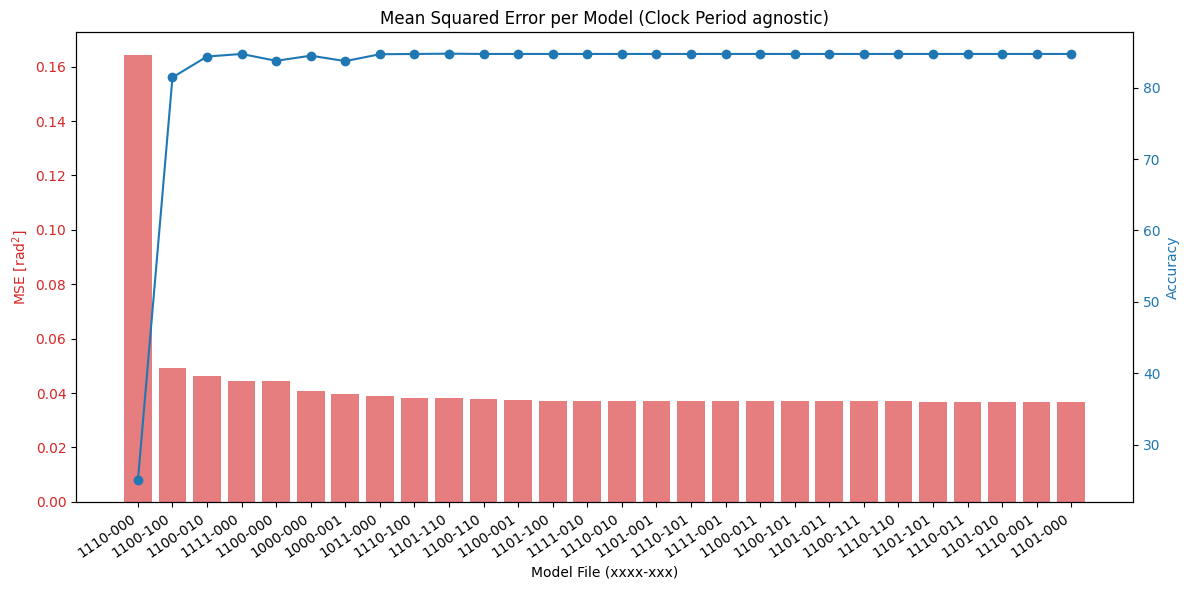

In [20]:
import numpy as np
df_sorted = df.sort_values(by='mse', ascending=False).copy()

# Extract "xxxx-xxx" from "x-xxxx-xxx-..."
df_sorted['label'] = df_sorted['model_file'].str.split('-').str[1] + '-' + df_sorted['model_file'].str.split('-').str[2]

# X-axis values
x = range(len(df_sorted))
labels = df_sorted['label']

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for MSE
color1 = 'tab:red'
ax1.bar(x, df_sorted['mse'], color=color1, alpha=0.6, label='MSE')
ax1.set_ylabel(r'MSE [$\text{rad}^2$]', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
plt.xticks(x, labels, rotation=34, ha='right')
plt.xlabel('Model File (xxxx-xxx)')
#ax1.semilogy()

# Accuracy plot
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.plot(x, 100.0*df_sorted['accuracy'], color=color2, marker='o', label='Accuracy')
ax2.set_ylabel('Accuracy', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
plt.xticks(x, labels, rotation=34, ha='right')
plt.xlabel('Model File (xxxx-xxx)')

# X-axis labels
plt.xticks(x, labels, rotation=34, ha='right')
plt.xlabel('Model File (xxxx-xxx)')
plt.title('Mean Squared Error per Model (Clock Period agnostic)')
plt.tight_layout()
plt.show()

# Latency Metrics

In [26]:
df = pd.read_csv('filtered_models.csv',dtype=str)
df = df[df['Valid']=='True']
df = df[df['TargetClock']=='100.0']
df['N_Layers']=df['Conv'].apply(lambda x: str(x).count('1')) + \
               df['Dense'].apply(lambda x :str(x).count('1')) + 3
latency = df[['N_Layers','BestLatency','WorstLatency']]

latency['BestLatency'] = pd.to_numeric(latency['BestLatency'], errors='coerce')/(100*1e6)*1e3
latency['WorstLatency'] = pd.to_numeric(latency['WorstLatency'], errors='coerce')/(100*1e6)*1e3
latency['N_Layers'] = pd.to_numeric(latency['N_Layers'], errors='coerce')

/tmp/ipykernel_696936/1616550609.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latency['BestLatency'] = pd.to_numeric(latency['BestLatency'], errors='coerce')/(100*1e6)*1e3
/tmp/ipykernel_696936/1616550609.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latency['WorstLatency'] = pd.to_numeric(latency['WorstLatency'], errors='coerce')/(100*1e6)*1e3
/tmp/ipykernel_696936/1616550609.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

/tmp/ipykernel_696936/4236020888.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='N_Layers', y='Latency', data=latency_df, inner='box', palette='pastel')  # or try 'Set2', 'pastel', etc.


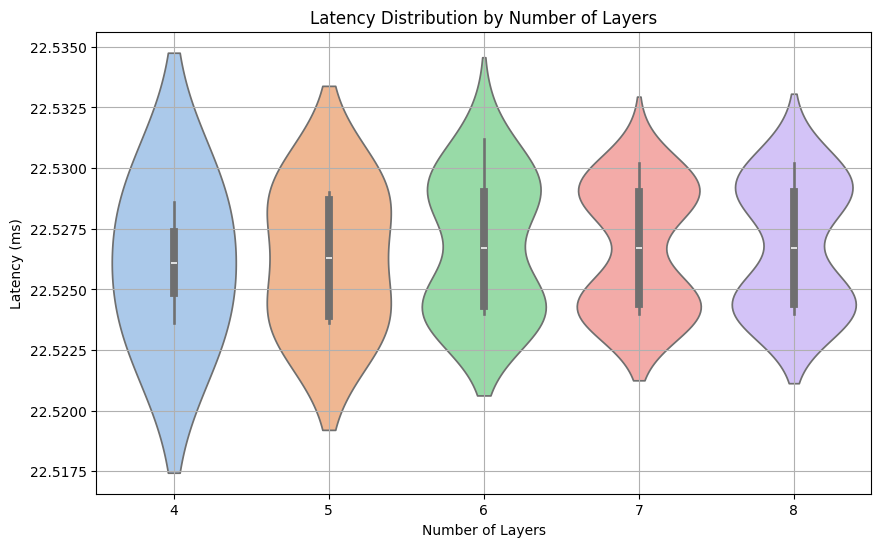

In [53]:

# Stack BestLatency and WorstLatency into one column
latency_df = pd.concat([
    df[['N_Layers', 'BestLatency']].rename(columns={'BestLatency': 'Latency'}),
    df[['N_Layers', 'WorstLatency']].rename(columns={'WorstLatency': 'Latency'})
])

latency_df['Latency'] = pd.to_numeric(latency_df['Latency'], errors='coerce') * (100 * 1e-9) * 1e3
latency_df['N_Layers'] = pd.to_numeric(latency_df['N_Layers'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.violinplot(x='N_Layers', y='Latency', data=latency_df, inner='box', palette='pastel')  # or try 'Set2', 'pastel', etc.
plt.xlabel("Number of Layers")
plt.ylabel("Latency (ms)")
plt.title("Latency Distribution by Number of Layers")
plt.grid(True)
plt.show()

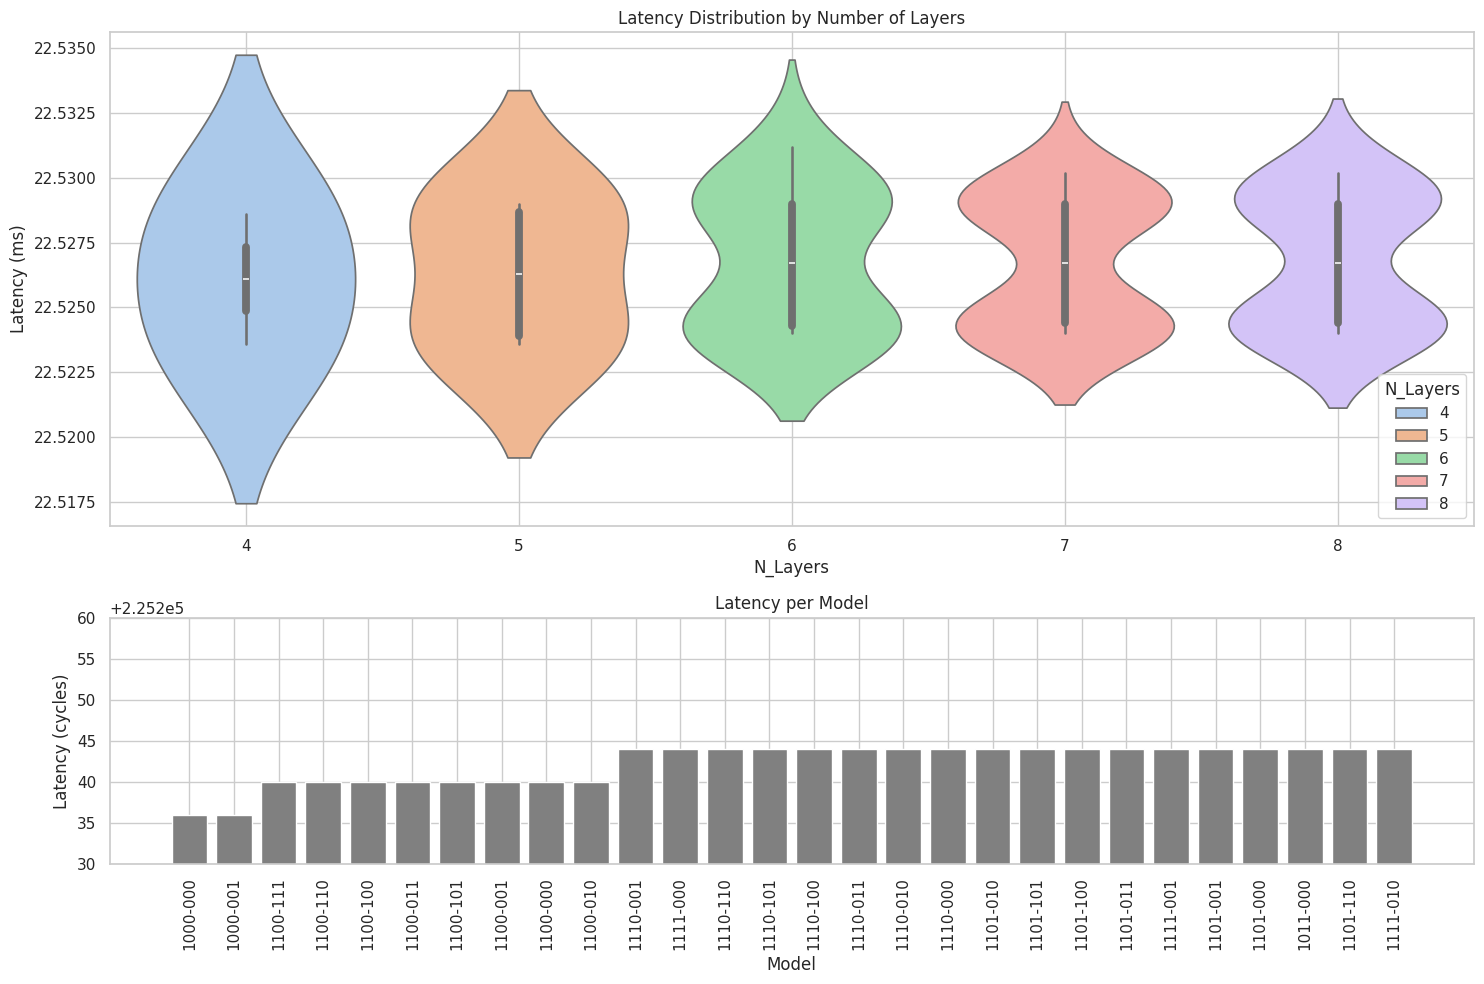

In [60]:

# Assume:
# - latency_df: columns ['N_Layers', 'Latency'] (float)
# - df: original dataframe, dtype=str

# Filter models where TargetClock == 100.0
df_filtered = df[df['TargetClock'] == '100.0'].copy()
df_filtered['WorstLatency'] = df_filtered['BestLatency'].astype(float)
df_filtered['N_Layers'] = df_filtered['N_Layers'].astype(int)
df_filtered['Weights'] = df_filtered['Weights'].astype(int)
df_filtered['Connections'] = df_filtered['Connections'].astype(int)
df_filtered['LUT'] = df_filtered['LUT'].astype(int)
df_filtered['BRAM'] = df_filtered['BRAM'].astype(int)

# Create model name from Conv and Dense
df_filtered['Model'] = df_filtered['Conv'] + '-' + df_filtered['Dense']

# Sort models by latency for better bar ordering
df_filtered = df_filtered.sort_values('WorstLatency')

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=False, gridspec_kw={'height_ratios': [2, 1]})

# Top: Violin plot of latency distribution by N_Layers
sns.violinplot(x='N_Layers', y='Latency', data=latency_df, inner='box', palette='pastel', ax=ax1, hue='N_Layers')
ax1.set_title("Latency Distribution by Number of Layers")
ax1.set_ylabel("Latency (ms)")
ax1.grid(True)

# Bottom: Bar plot of WorstLatency per model
ax2.bar(df_filtered['Model'], df_filtered['WorstLatency'], color='gray')
ax2.set_title("Latency per Model")
ax2.set_ylabel("Latency (cycles)")
ax2.set_xlabel("Model")
ax2.tick_params(axis='x', rotation=90)
ax2.grid(True, axis='y')
ax2.set_ylim([225_230, 225_260])

plt.tight_layout()
plt.show()

In [61]:
df_filtered

,Conv,Dense,Height,Width,Mult,Weights,Connections,BRAM,LUT,FF,URAM,DSP,EstimatedClock,TargetClock,BestLatency,WorstLatency,Valid,N_Layers,Model
259,1000,000,64,64,0.1,933,79476,18,21373,15991,0,13,24.118,100.0,225236,225236.0,True,4,1000-000
263,1000,001,64,64,0.1,935,79477,18,21723,16195,0,13,26.708,100.0,225236,225236.0,True,5,1000-001
415,1100,111,64,64,0.1,2084,92606,34,18671,11029,0,42,24.408,100.0,225240,225240.0,True,8,1100-111
411,1100,110,64,64,0.1,2082,92605,34,18331,10827,0,42,24.408,100.0,225240,225240.0,True,7,1100-110
403,1100,100,64,64,0.1,2032,92560,33,16975,10311,0,41,24.408,100.0,225240,225240.0,True,6,1100-100
399,1100,011,64,64,0.1,1399,91931,29,16069,10225,0,26,24.408,100.0,225240,225240.0,True,7,1100-011
407,1100,101,64,64,0.1,2034,92561,33,17325,10515,0,41,24.408,100.0,225240,225240.0,True,7,1100-101
391,1100,001,64,64,0.1,889,91426,24,14626,9736,0,13,24.408,100.0,225240,225240.0,True,6,1100-001
387,1100,000,64,64,0.1,887,91425,24,14270,9532,0,13,21.818,100.0,225240,225240.0,True,5,1100-000
395,1100,010,64,64,0.1,1397,91930,29,15728,10021,0,26,24.408,100.0,225240,225240.0,True,6,1100-010


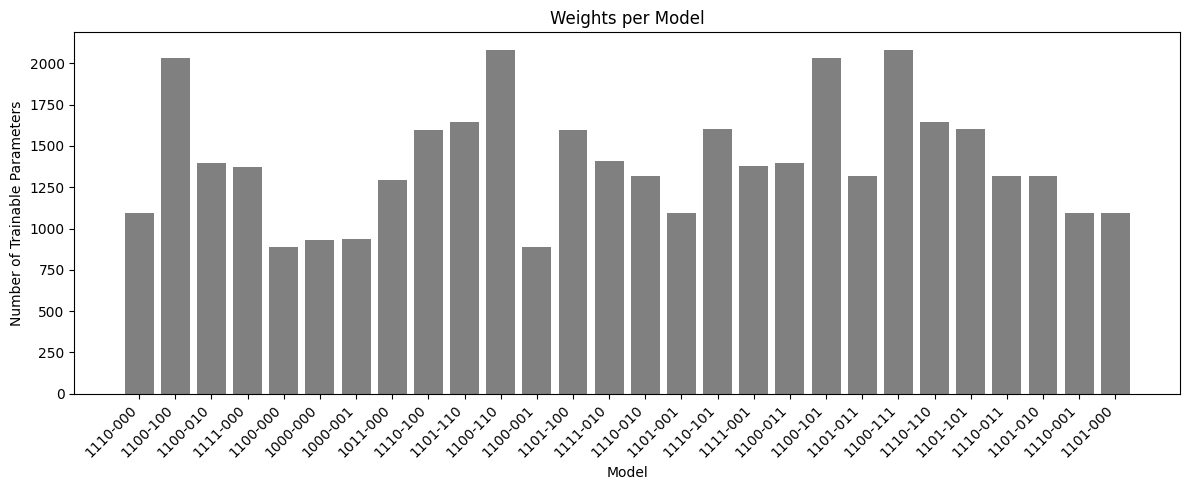

In [40]:
# Get the model order from df_sorted
model_order = df_sorted['label'].values

# Reindex df_filtered to follow that order
df_ordered = df_filtered.set_index('Model').loc[model_order].reset_index()

# Plot Weights per model
plt.figure(figsize=(12, 5))
plt.bar(df_ordered['Model'], df_ordered['Weights'], color='gray')
plt.title("Weights per Model")
plt.xlabel("Model")
plt.ylabel("Number of Trainable Parameters")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

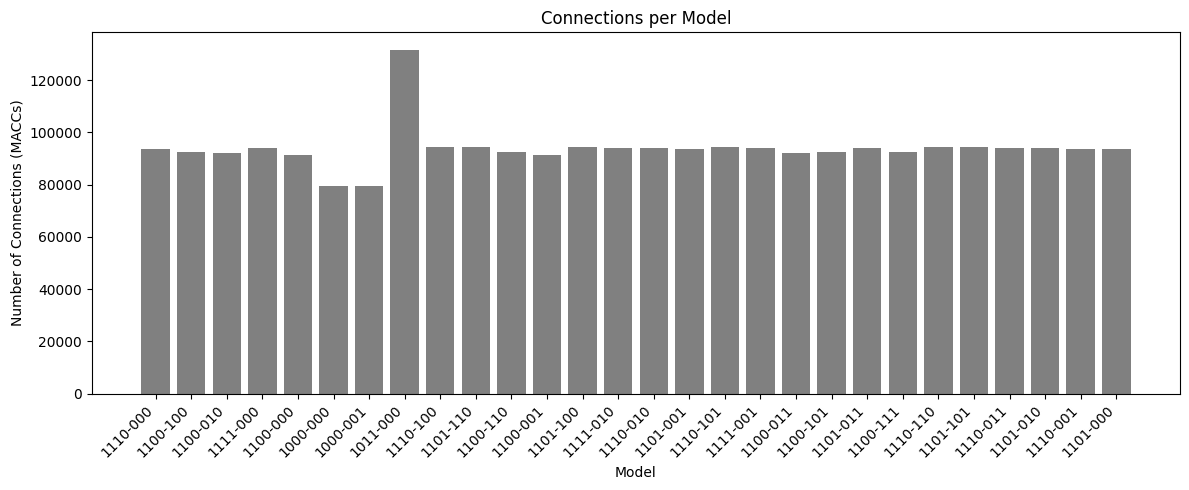

In [42]:
# Get the model order from df_sorted
model_order = df_sorted['label'].values

# Reindex df_filtered to follow that order
df_ordered = df_filtered.set_index('Model').loc[model_order].reset_index()

# Plot Weights per model
plt.figure(figsize=(12, 5))
plt.bar(df_ordered['Model'], df_ordered['Connections'], color='gray')
plt.title("Connections per Model")
plt.xlabel("Model")
plt.ylabel("Number of Connections (MACCs)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

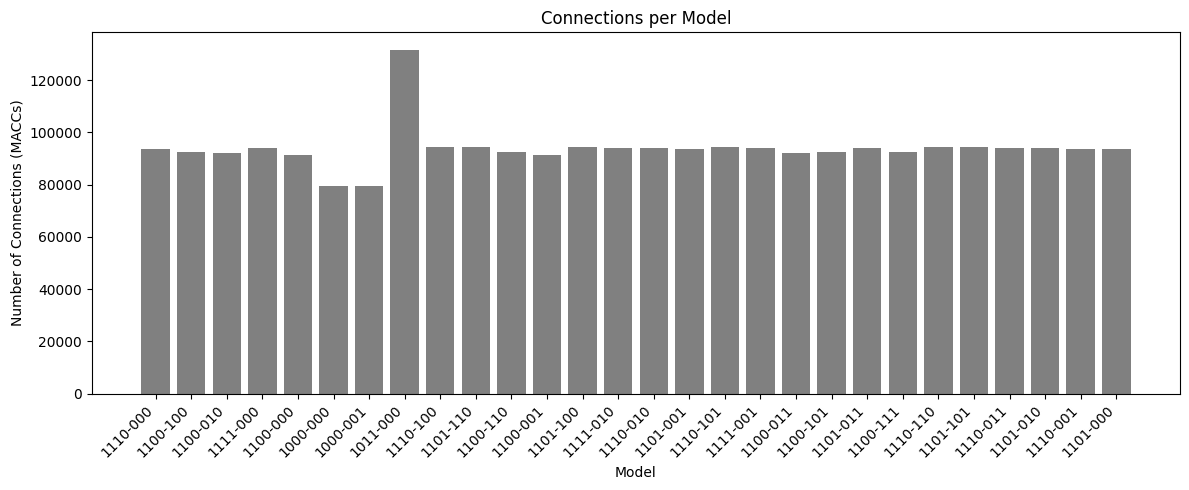

In [43]:
# Get the model order from df_sorted
model_order = df_sorted['label'].values

# Reindex df_filtered to follow that order
df_ordered = df_filtered.set_index('Model').loc[model_order].reset_index()

# Plot Weights per model
plt.figure(figsize=(12, 5))
plt.bar(df_ordered['Model'], df_ordered['Connections'], color='gray')
plt.title("Connections per Model")
plt.xlabel("Model")
plt.ylabel("Number of Connections (MACCs)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [50]:
# First, make sure Model is the index (or join on it)
df_lut_filtered = df_filtered[df_filtered['LUT'] < 20800]

# Filter df_sorted using only models that pass the LUT constraint
df_constrained = df_sorted[df_sorted['label'].isin(df_lut_filtered['Model'])]
print(len(df_constrained), len(df_sorted))

25 28


In [51]:
df_constrained

,model_file,clock,accuracy,mse,folder,label
8,0-1110-000-0.1-100-30-50-70.h5,100-30-50-70,0.2500,0.164430,models/deeppicar-stats/models/1110-000_64x64x1...,1110-000
26,2-1100-100-0.1-100-30-50-70.h5,100-30-50-70,0.8144,0.049358,models/deeppicar-stats/models/1100-100_64x64x1...,1100-100
24,2-1100-010-0.1-100-30-50-70.h5,100-30-50-70,0.8436,0.046295,models/deeppicar-stats/models/1100-010_64x64x1...,1100-010
1,0-1111-000-0.1-100-30-50-70.h5,100-30-50-70,0.8472,0.044295,models/deeppicar-stats/models/1111-000_64x64x1...,1111-000
6,0-1100-000-0.1-100-30-50-70.h5,100-30-50-70,0.8376,0.044256,models/deeppicar-stats/models/1100-000_64x64x1...,1100-000
17,0-1110-100-0.1-100-30-50-70.h5,100-30-50-70,0.8472,0.038181,models/deeppicar-stats/models/1110-100_64x64x1...,1110-100
5,0-1101-110-0.1-100-50-70.h5,100-50-70,0.8476,0.038015,models/deeppicar-stats/models/1101-110_64x64x1...,1101-110
0,2-1100-110-0.1-100-30-50-70.h5,100-30-50-70,0.8472,0.037765,models/deeppicar-stats/models/1100-110_64x64x1...,1100-110
20,1-1100-001-0.1-100-30-50-70.h5,100-30-50-70,0.8472,0.037275,models/deeppicar-stats/models/1100-001_64x64x1...,1100-001
9,2-1101-100-0.1-100-30-50-70.h5,100-30-50-70,0.8472,0.037248,models/deeppicar-stats/models/1101-100_64x64x1...,1101-100


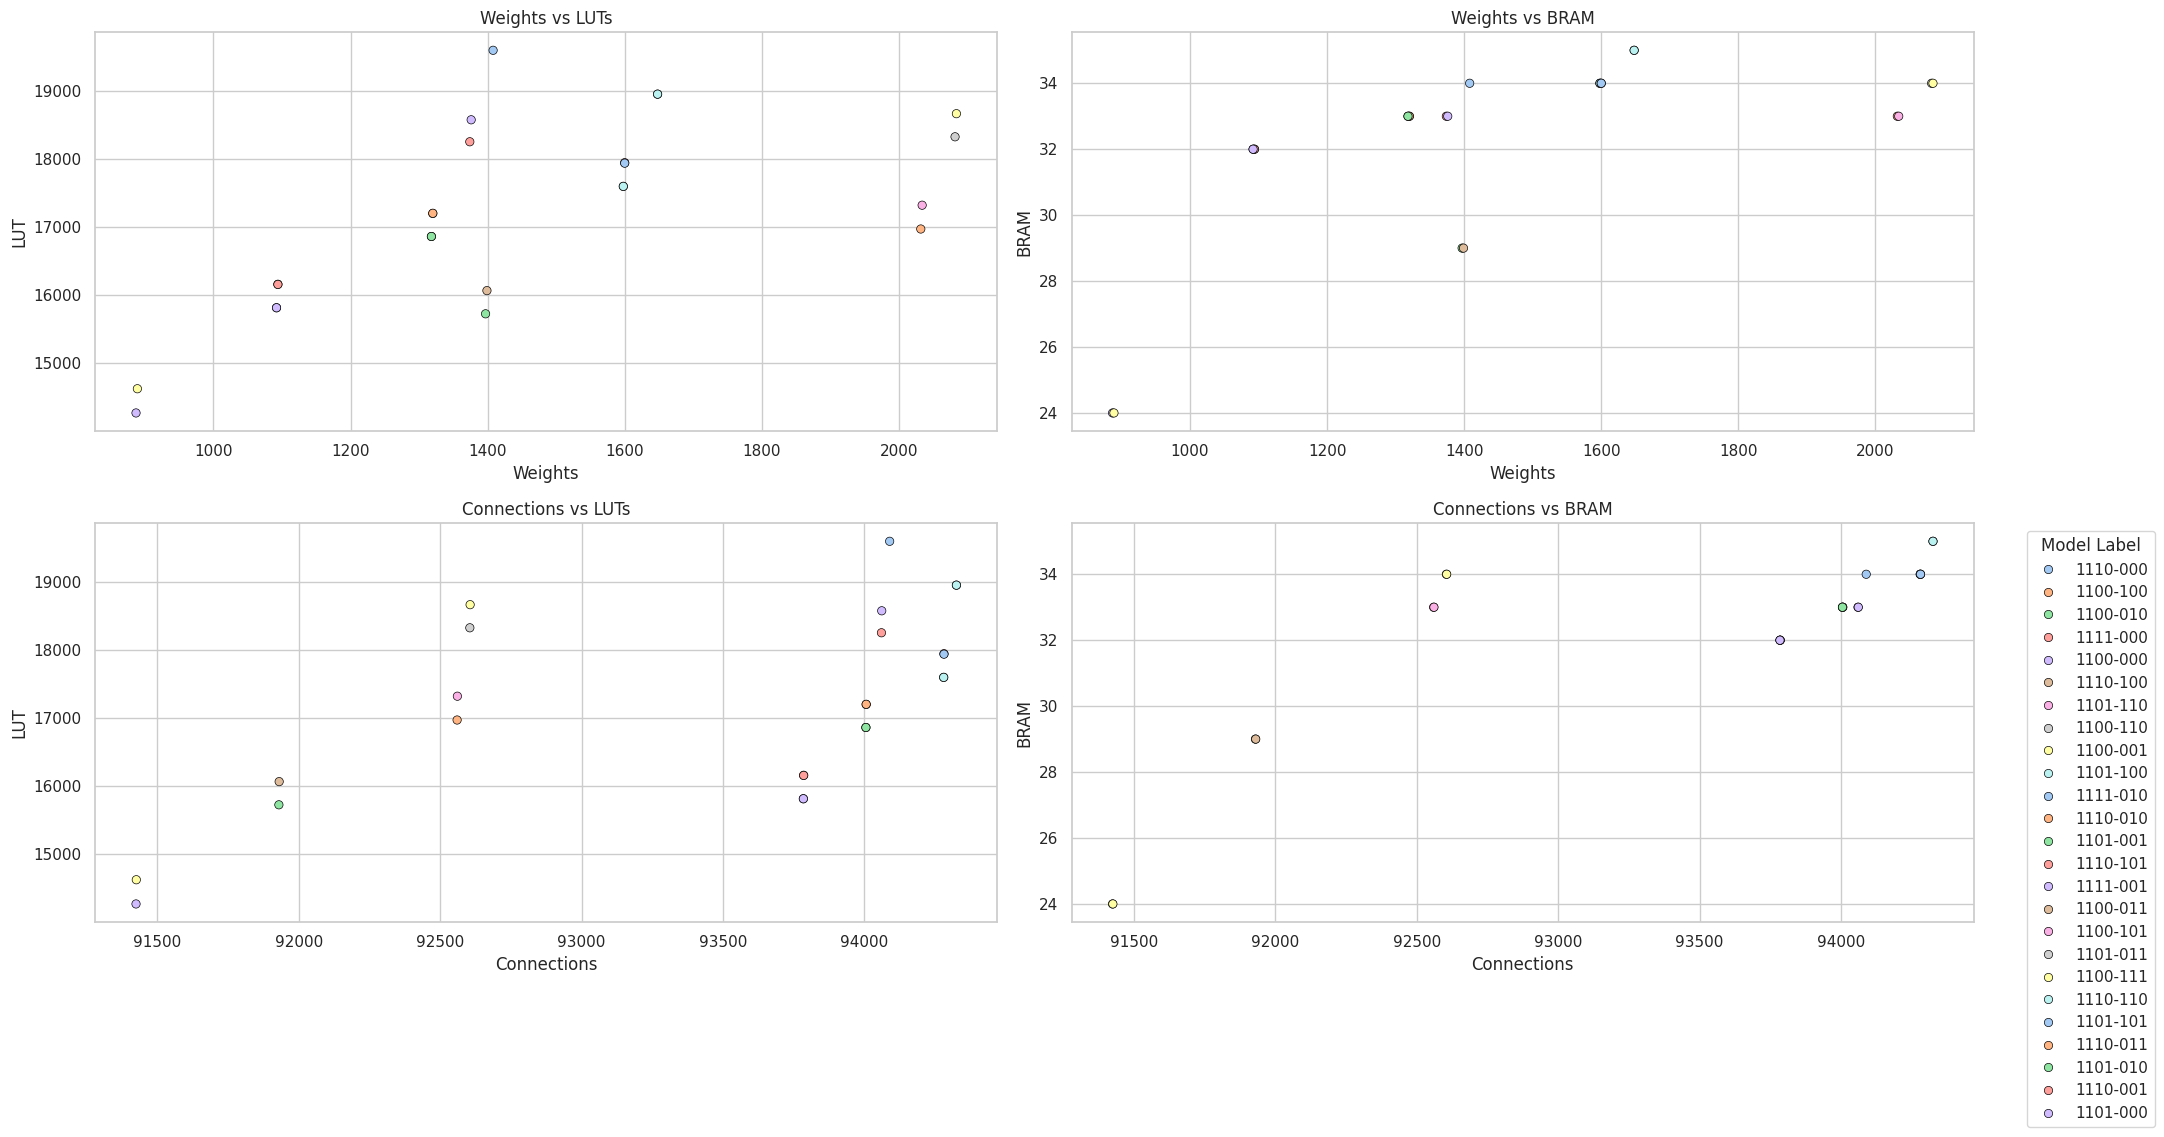

In [ ]:

# Set Seaborn style
sns.set_theme(style="whitegrid", palette="pastel")

# Subset to constrained models
df_plot = df_filtered.loc[df_constrained.index].copy()
df_plot = df_plot.reset_index().rename(columns={'index': 'label'})

# Add hue category for consistent coloring
df_plot['label'] = df_plot['label'].astype(str)  # Ensure string for consistent hue mapping

# Set up 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

# Plot 1: Weights vs LUT
sns.scatterplot(data=df_plot, x='Weights', y='LUT', hue='label', ax=axs[0, 0], palette='pastel', edgecolor='black')
axs[0, 0].set_title('Weights vs LUTs')

# Plot 2: Weights vs BRAM
sns.scatterplot(data=df_plot, x='Weights', y='BRAM', hue='label', ax=axs[0, 1], palette='pastel', edgecolor='black')
axs[0, 1].set_title('Weights vs BRAM')

# Plot 3: Connections vs LUT
sns.scatterplot(data=df_plot, x='Connections', y='LUT', hue='label', ax=axs[1, 0], palette='pastel', edgecolor='black')
axs[1, 0].set_title('Connections vs LUTs')

# Plot 4: Connections vs BRAM
sns.scatterplot(data=df_plot, x='Connections', y='BRAM', hue='label', ax=axs[1, 1], palette='pastel', edgecolor='black')
axs[1, 1].set_title('Connections vs BRAM')

# Adjust layout and legend
for ax in axs.flat:
    ax.legend().remove()  # Hide repeated legends

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Model Label')
plt.show()